In [1]:
#importing 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import networkx as nx


#loading classes 
from MiniBatchKMeans import MiniBatchKMeans
from MarkovChain import MarkovChain



In [2]:
# Data preprocessing

#load 

data = pd.read_csv('MetroPT3(AirCompressor).csv', parse_dates=['timestamp']) 

features = data.drop(columns=['timestamp'])

# continuous columns and boolean columns 

continuous_cols = ["TP2","TP3","H1","DV_pressure","Reservoirs", "Oil_temperature","Motor_current"]

boolean_cols = ["COMP","DV_eletric","Towers","MPG","LPS","Pressure_switch","Oil_level","Caudal_impulses"]

# Change window size because 10 seconds between each measurement is too small 

window_size = 30 # 5 minute window (1 row -> 10 seconds , 30 rows -> 5 minutes)

n_windows = len(features) // window_size

X = np.zeros((n_windows, (4*len(continuous_cols) + len(boolean_cols))))

for i in range(n_windows):
    window = features.iloc[i*window_size:(i+1)*window_size]
    
    # Continuous features: mean , std and min , max
    cont_means = window[continuous_cols].mean().values
    cont_stds = window[continuous_cols].std().values
    cont_mins = window[continuous_cols].min().values
    cont_maxs = window[continuous_cols].max().values
    
    # Boolean features: % of time True
    bool_props = window[boolean_cols].mean().values
    
    X[i] = np.concatenate([cont_means, cont_stds,cont_mins, cont_maxs, bool_props])






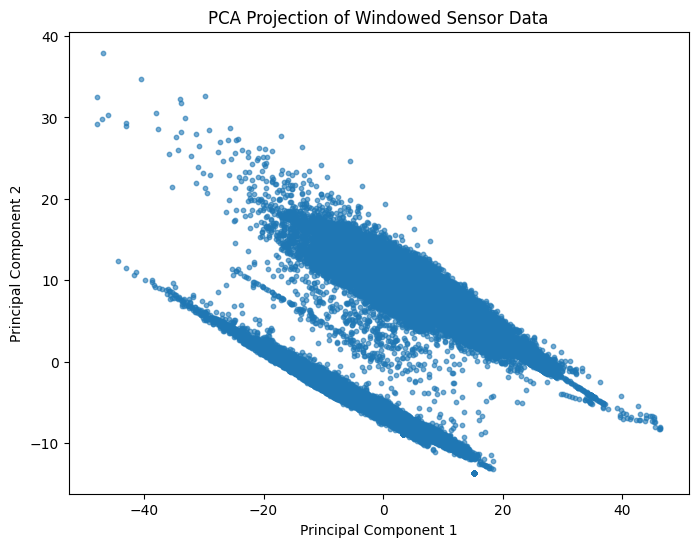

In [3]:
# View data to chose numer of lcusters 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Windowed Sensor Data')
plt.show()

In [ ]:
#split the data into train for the first month and test for the rest of the data 

month = (30 * 24 * 60) // 5  # first month (30 days) of 5-minute windows

train_size = 5*month # first 5 months for training

X_train = X[:train_size]


X_test = X[train_size:]
# reloading classes to  debug 
from MiniBatchKMeans import MiniBatchKMeans
from MarkovChain import MarkovChain
#init kmeans with 3 clusters 

kmeans = MiniBatchKMeans(n_clusters=6, max_iters=1000)
clusters, labels = kmeans.fit(X_train)

#switch the labels for the failures to be 0 
#find the index of the failure ( 4/18/2020)

# set neighboring points to failure state as well because the failure might not be instant (and if not, there are not enough failure points to train the markov chain)

# 1st failure
failure_start = pd.Timestamp('2020-04-18 00:00:00') - pd.Timedelta(days=5)
failure_end   = pd.Timestamp('2020-04-18 23:59:00')

failure_indices = data.index[(data['timestamp'] >= failure_start) & (data['timestamp'] <= failure_end)]

# 2nd failure
failure_start = pd.Timestamp('2020-05-29 23:30:00')   - pd.Timedelta(days=5)
failure_end   = pd.Timestamp('2020-05-30 06:00:00')

failure_indices = failure_indices.append(data.index[(data['timestamp'] >= failure_start) & (data['timestamp'] <= failure_end)])

# 3rd failure
failure_start = pd.Timestamp('2020-06-05 10:00:00')  - pd.Timedelta(days=5)
failure_end   = pd.Timestamp('2020-06-07 14:30:00')

failure_indices = failure_indices.append(data.index[(data['timestamp'] >= failure_start) & (data['timestamp'] <= failure_end)])

# 4th failure
failure_start = pd.Timestamp('2020-07-15 14:30:00')  - pd.Timedelta(days=5)
failure_end   = pd.Timestamp('2020-07-15 19:00:00')

failure_indices = failure_indices.append(data.index[(data['timestamp'] >= failure_start) & (data['timestamp'] <= failure_end)])




# convert row indices to window indices
failure_windows = failure_indices // window_size

# set failure cluster label to 0 in your labels
failure_state = kmeans.n_clusters  # new label for failure state
if failure_windows.min() < len(labels):  # in bbounds
    labels[failure_windows] = failure_state

# print labels to verify 

"""
for i in range(len(labels)):
    print(f"Label {i}: {labels[i]}")
"""









#init markov chain
markov = MarkovChain(kmeans.n_clusters)
markov.fit([labels])









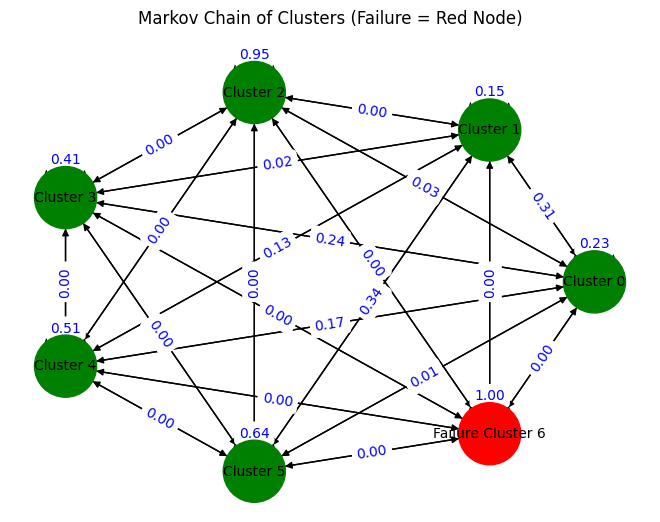

In [ ]:
#markov visualization

G = nx.DiGraph()
for i in range(kmeans.n_clusters+1):
    if i == kmeans.n_clusters:
        G.add_node(i, color='red', label=f'Failure Cluster {i}')
    else:
        G.add_node(i, color='green', label=f'Cluster {i}')

# Add edges with probabilities
for i in range(kmeans.n_clusters+1):
    for j in range(kmeans.n_clusters+1):
        prob = markov.transition_matrix[i, j]
        #if prob > 0:  # show only existing transitions
        G.add_edge(i, j, weight=prob)

# Draw the graph
pos = nx.circular_layout(G)
colors = [G.nodes[n]['color'] for n in G.nodes]
labels = {n: G.nodes[n]['label'] for n in G.nodes}
edge_labels = {(i,j): f"{d['weight']:.2f}" for i,j,d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, labels=labels, node_color=colors, node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')
plt.title("Markov Chain of Clusters (Failure = Red Node)")
plt.show()

[[ 10.29833593   7.54098465]
 [ -5.92725186  13.41941467]
 [ 21.15017473   1.91259927]
 [  3.92785699  -7.52542681]
 [ -8.27004318  -3.15447278]
 [-17.70543097   0.83708512]]


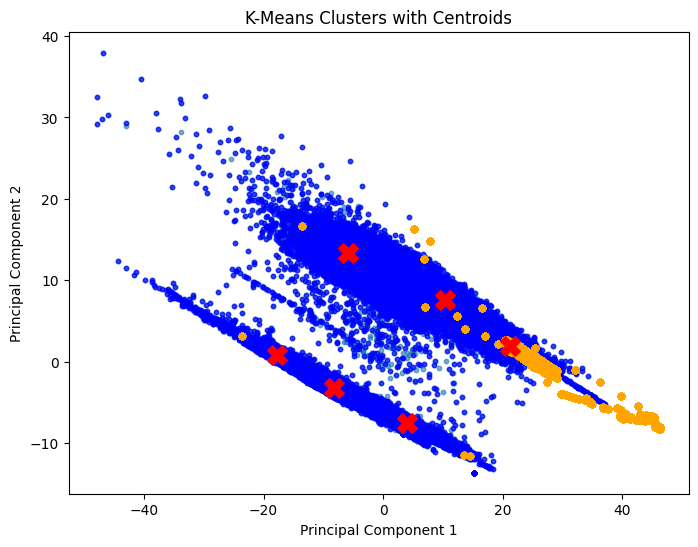

In [ ]:
# Visualizing kmeans clusters on PCA plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_train_pca = pca.transform(X_train)


centroids = pca.transform(kmeans.centroids)
print(centroids)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], s=10, alpha=0.6, c='blue', label='Training Data')
#scatter failer points in different color 
failure_pca = X_pca[failure_windows[failure_windows < len(X_pca)]]
plt.scatter(failure_pca[:,0], failure_pca[:,1], s=20, c='orange', label='Failure Windows')
plt.scatter(centroids[:,0], centroids[:,1], s=200, c='red', marker='X', label='Centroids')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clusters with Centroids')
plt.show()

In [ ]:
# so we kind of have a cluster for the failures (orange points) it looks to be the 5th centroid (4) we can try and use it to predict the failures

failure_centroid = kmeans.centroids[4]  # assuming the 5th centroid corresponds to failures
# Predict on new data points
for x in X_test:
    failure = kmeans.predict_failure(x, failure_centroid)
    print(f"Predicted probability of failure for new data point: {failure:.4f}")








Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new data point: 0.0000
Predicted probability of failure for new

In [ ]:
# continue training on new data 
new_X_train = X_test[:month]  
rest_X_test = X_test[month:]  # remaining windows for testing

kmeans.partial_fit(new_X_train)  # continue training on new data // need to partial fit the first data for this to make any sense 

# Predict on new data points

for x in rest_X_test:
    failure = kmeans.predict_failure(x, failure_centroid)
    print(f"Predicted probability of failure for new data point: {failure:.4f}")